In [1]:
import pandas as pd

# Import the CSV file
data = pd.read_csv('Desktop/Data Science/Task2.csv')

# Create a backup dataset
data_b = pd.read_csv('Desktop/Data Science/Task2.csv')

# Preview the data
print(data.head())

print(data.info())

   moderator  id_request         request_time           start_time  \
0        165      159660   2020-09-24 7:01:16  2020-10-01 16:00:31   
1        178      160116  2020-09-24 22:32:15  2020-10-01 13:21:42   
2        187      160178   2020-09-25 2:58:13  2020-10-02 11:37:16   
3        178      160306   2020-09-25 9:44:12   2020-10-02 7:23:09   
4        178      163042  2020-09-30 15:56:08   2020-10-02 7:37:33   

           finish_time       team  
0  2020-10-01 16:02:02     retail  
1  2020-10-01 13:21:43     retail  
2  2020-10-02 11:41:56  wholesale  
3   2020-10-02 7:25:33     retail  
4   2020-10-02 7:47:57     retail  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   moderator     35617 non-null  int64 
 1   id_request    35617 non-null  int64 
 2   request_time  35617 non-null  object
 3   start_time    35617 non-null  object
 4 

In [2]:
# Converting time columns to datetime
for col in ['request_time', 'start_time', 'finish_time']:
    data[col] = pd.to_datetime(data[col])
for col in ['request_time', 'start_time', 'finish_time']:
    data_b[col] = pd.to_datetime(data_b[col])
# Checking if it worked
print(data.loc[:, 'request_time'].dtype)

# Calculate 'answer_time' in minutes
data.loc[:, 'answer_time'] = (data.loc[:, 'start_time'] - data.loc[:, 'request_time']).dt.total_seconds() / 60

# Calculate 'work_time' in minutes
data.loc[:, 'work_time'] = (data.loc[:, 'finish_time'] - data.loc[:, 'start_time']).dt.total_seconds() / 60

datetime64[ns]


In [3]:
# Create datasets before and after anomally period
data_1pt = data[data['request_time'] < '2020-10-20']
data_2pt = data[data['request_time'] > '2020-10-29']

# Calculate the 99th threshold for the timespan befor anomally
threshold_1pt = data_1pt['answer_time'].quantile(0.99)
print("99th percentile threshold for 1pt:", threshold_1pt)  
high_values_1pt = data_1pt[data_1pt['answer_time'] > threshold_1pt]
print("Number of points in top 1% of datapoints in 1pt:", len(high_values_1pt))

# Calculate the 99th threshold for the timespan after anomally
threshold_2pt = data_2pt['answer_time'].quantile(0.99)
print("99th percentile threshold:", threshold_2pt)
high_values_2pt = data_2pt[data_2pt['answer_time'] > threshold_2pt]
print("Number of points in top 1% of datapoints in 2pt:", len(high_values_2pt))

# Create a dataset from anomalous timespan
anomalies = data[(data['request_time'] >= '2020-10-20') & (data['request_time'] <= '2020-10-29')]



99th percentile threshold for 1pt: 780.4460000000004
Number of points in top 1% of datapoints in 1pt: 42
99th percentile threshold: 7391.656166666667
Number of points in top 1% of datapoints in 2pt: 309


In [4]:
total_anomalies = len(anomalies)
count_above_1pt = len(high_values_1pt)
count_above_2pt = len(high_values_2pt)
print("Overall sum of anomalies is -", sum([total_anomalies,count_above_1pt,count_above_2pt]))
print("It is",sum([total_anomalies,count_above_1pt,count_above_2pt])/len(data)*100, "% of the data")

Overall sum of anomalies is - 941
It is 2.6419967992812423 % of the data


In [5]:
import numpy as np

# Cleaning the data from defined outliers
condition_1 = (
    ((data['request_time'] < '2020-10-20') & (data['answer_time'] <= threshold_1pt)) |
    ((data['request_time'] > '2020-10-29') & (data['answer_time'] <= threshold_2pt)) |
     ((data['request_time'] >= '2020-10-20') & (data['request_time'] <= '2020-10-29'))  & (data['answer_time']) 
)

data = data[condition_1]

data.loc[(data['request_time'] >= '2020-10-20') & (data['request_time'] <= '2020-10-29'), 'answer_time'] = np.nan

data[(data['request_time'] >= '2020-10-20') & (data['request_time'] <= '2020-10-29')].head()

,moderator,id_request,request_time,start_time,finish_time,team,answer_time,work_time
4163,170,171344,2020-10-20 00:42:57,2020-10-20 07:08:44,2020-10-20 07:12:05,wholesale,NaN,3.350000
4164,136,171345,2020-10-20 00:45:22,2020-10-20 07:09:24,2020-10-20 07:15:04,retail,NaN,5.666667
4165,143,171347,2020-10-20 00:49:31,2020-10-20 07:20:01,2020-10-20 07:20:10,wholesale,NaN,0.150000
4166,170,171348,2020-10-20 00:50:49,2020-10-20 07:12:05,2020-10-20 07:13:07,wholesale,NaN,1.033333
4167,170,171349,2020-10-20 00:54:04,2020-10-20 07:13:08,2020-10-20 07:14:38,wholesale,NaN,1.500000


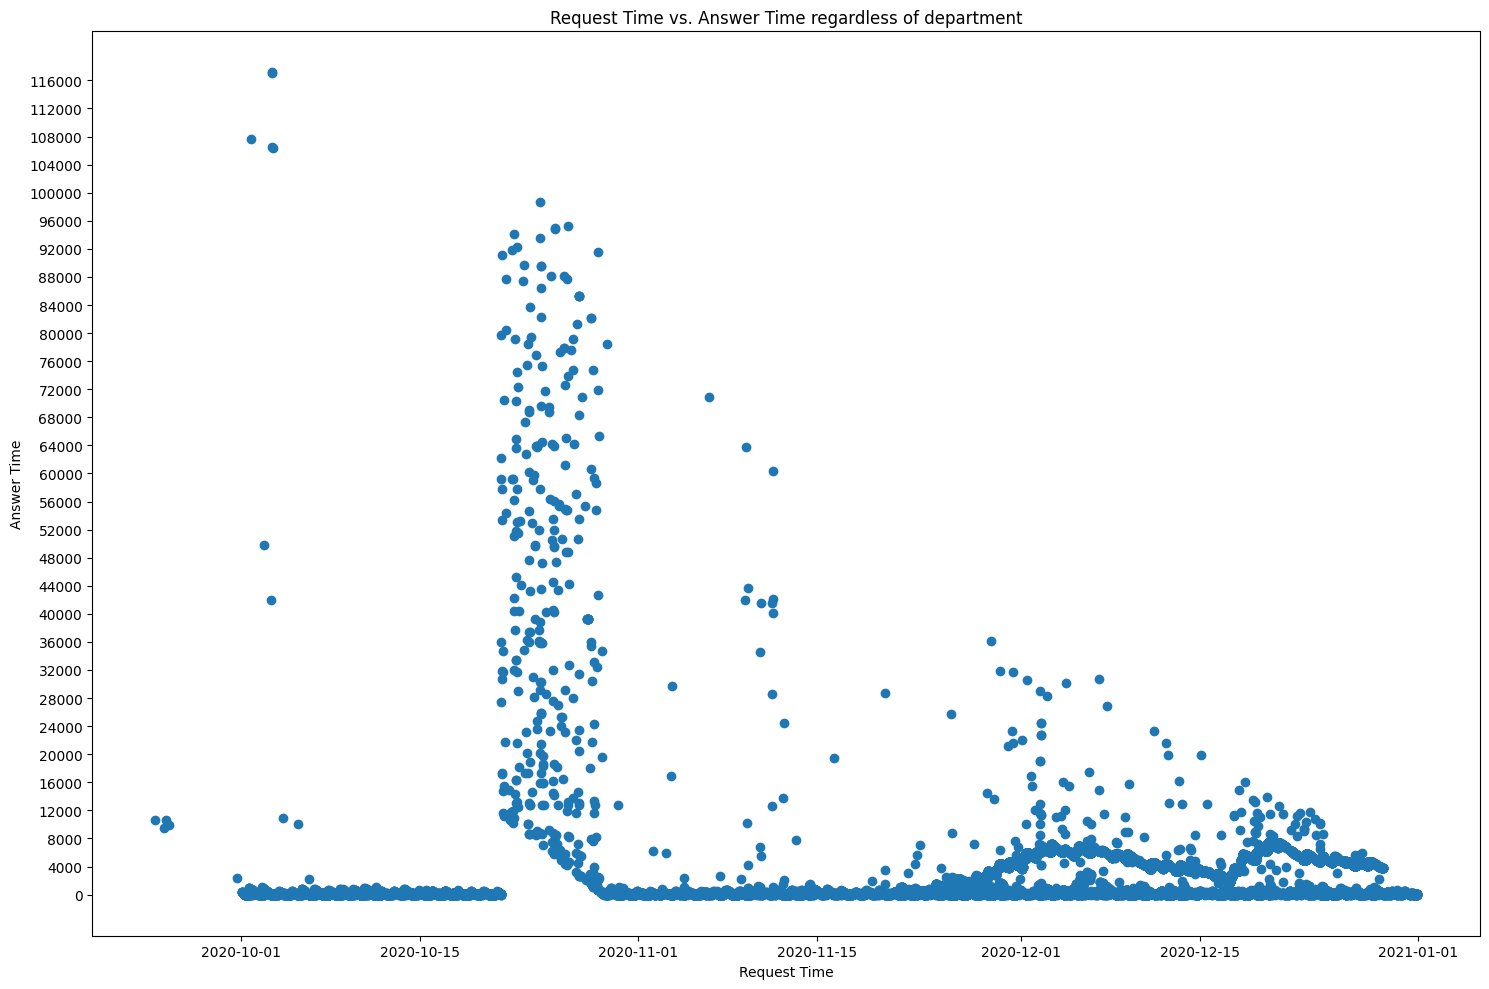

In [6]:
import matplotlib.pyplot as plt

data_b.loc[:, 'answer_time'] = (data_b.loc[:, 'start_time'] - data_b.loc[:, 'request_time']).dt.total_seconds() / 60

plt.figure(figsize=(15, 10))
plt.scatter(data_b['request_time'], data_b['answer_time'])

plt.xlabel("Request Time")
plt.ylabel("Answer Time")
plt.title("Request Time vs. Answer Time regardless of department")
plt.yticks(range(0, int(data_b['answer_time'].max()) + 100, 4000))
plt.tight_layout()
plt.show()

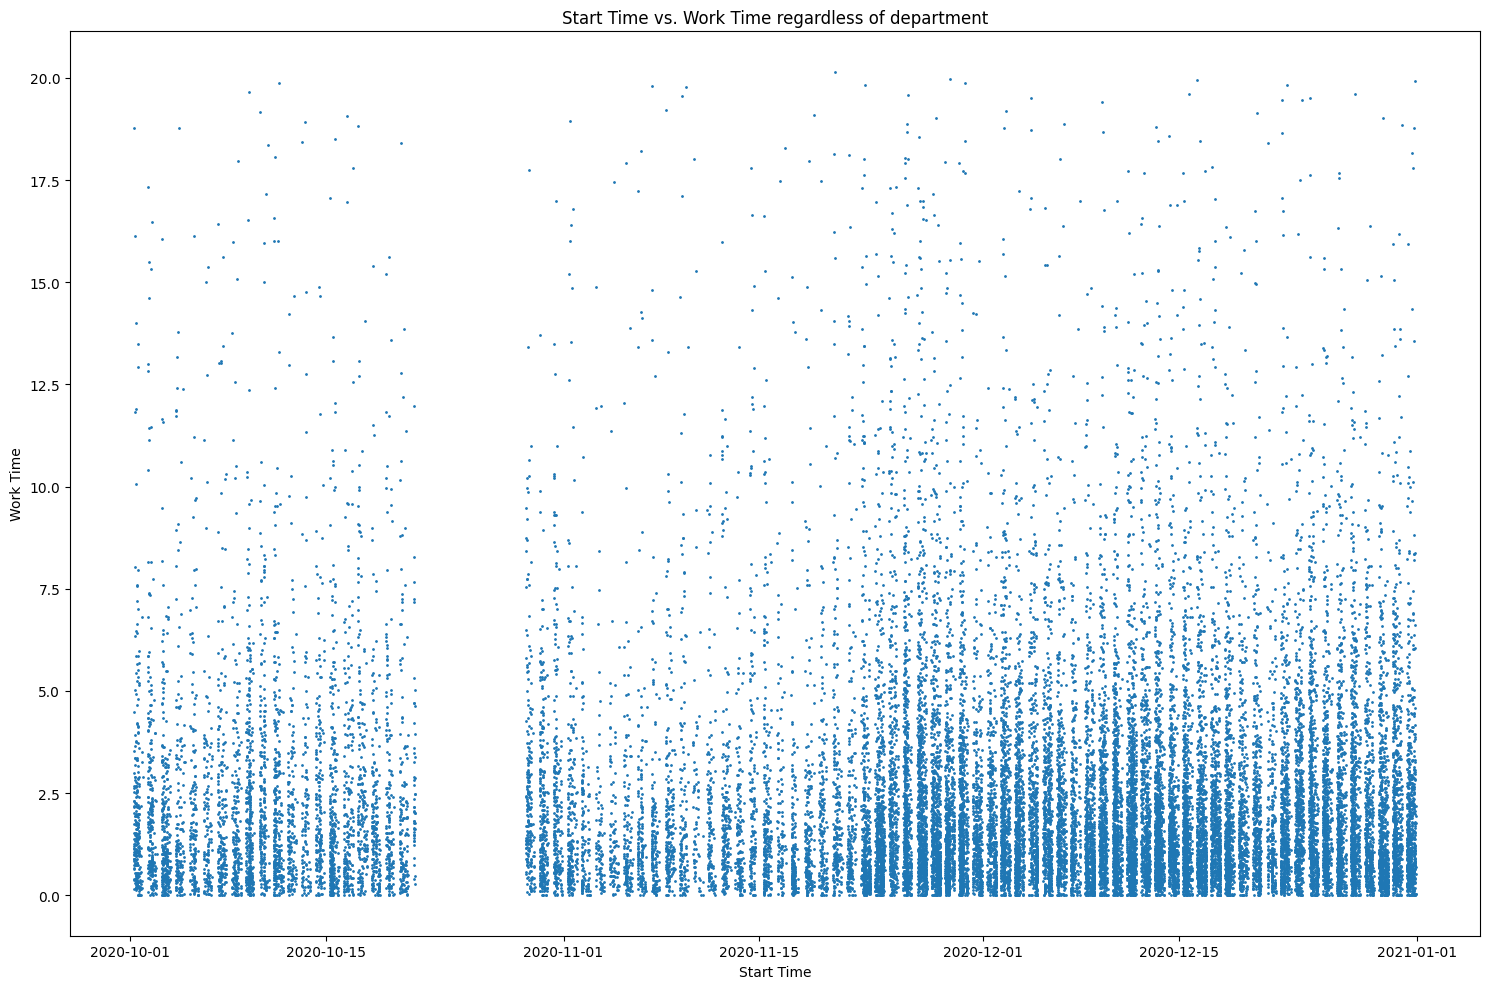

In [7]:
import matplotlib.pyplot as plt

data_b.loc[:, 'work_time'] = (data_b.loc[:, 'finish_time'] - data_b.loc[:, 'start_time']).dt.total_seconds() / 60

plt.figure(figsize=(15, 10))
plt.scatter(data_b['start_time'], data_b['work_time'], s = 1)

plt.xlabel("Start Time")
plt.ylabel("Work Time")
plt.title("Start Time vs. Work Time regardless of department")
plt.tight_layout()
plt.show()

In [8]:
# Create variables useful for the imputation
data['dayofweek'] = data['request_time'].dt.dayofweek
data['hour'] = data['request_time'].dt.hour
data['mod_code'] = data['moderator'].astype('category').cat.codes

data.head()

,moderator,id_request,request_time,start_time,finish_time,team,answer_time,work_time,dayofweek,hour,mod_code
5,128,163426,2020-10-01 00:58:24,2020-10-01 07:07:31,2020-10-01 07:08:22,wholesale,369.116667,0.850000,3,0,14
6,128,163427,2020-10-01 01:02:20,2020-10-01 08:03:58,2020-10-01 08:06:52,wholesale,421.633333,2.900000,3,1,14
7,128,163428,2020-10-01 01:04:15,2020-10-01 07:09:57,2020-10-01 07:12:06,wholesale,365.700000,2.150000,3,1,14
8,128,163429,2020-10-01 01:07:15,2020-10-01 07:12:06,2020-10-01 07:13:15,wholesale,364.850000,1.150000,3,1,14
9,128,163431,2020-10-01 01:14:13,2020-10-01 07:16:04,2020-10-01 07:17:05,wholesale,361.850000,1.016667,3,1,14


In [9]:
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer

# Setting the seed
np.random.seed(5742)

# Turning some variables into dummies
dow_dummies = pd.get_dummies(data['dayofweek'], prefix='dow')
hr_dummies  = pd.get_dummies(data['hour'],      prefix='hr')
team_dummies = pd.get_dummies(data['team'],      prefix='team')

# Imputation dataframe
to_impute = pd.concat([
    data[['answer_time', 'work_time', 'mod_code']], 
    hr_dummies,
    dow_dummies,
    team_dummies
], axis=1)

# 5. Impute
imputer = IterativeImputer(max_iter=100, random_state=0,   min_value=0.0  )
imputed = imputer.fit_transform(to_impute)

data['answer_time'] = imputed

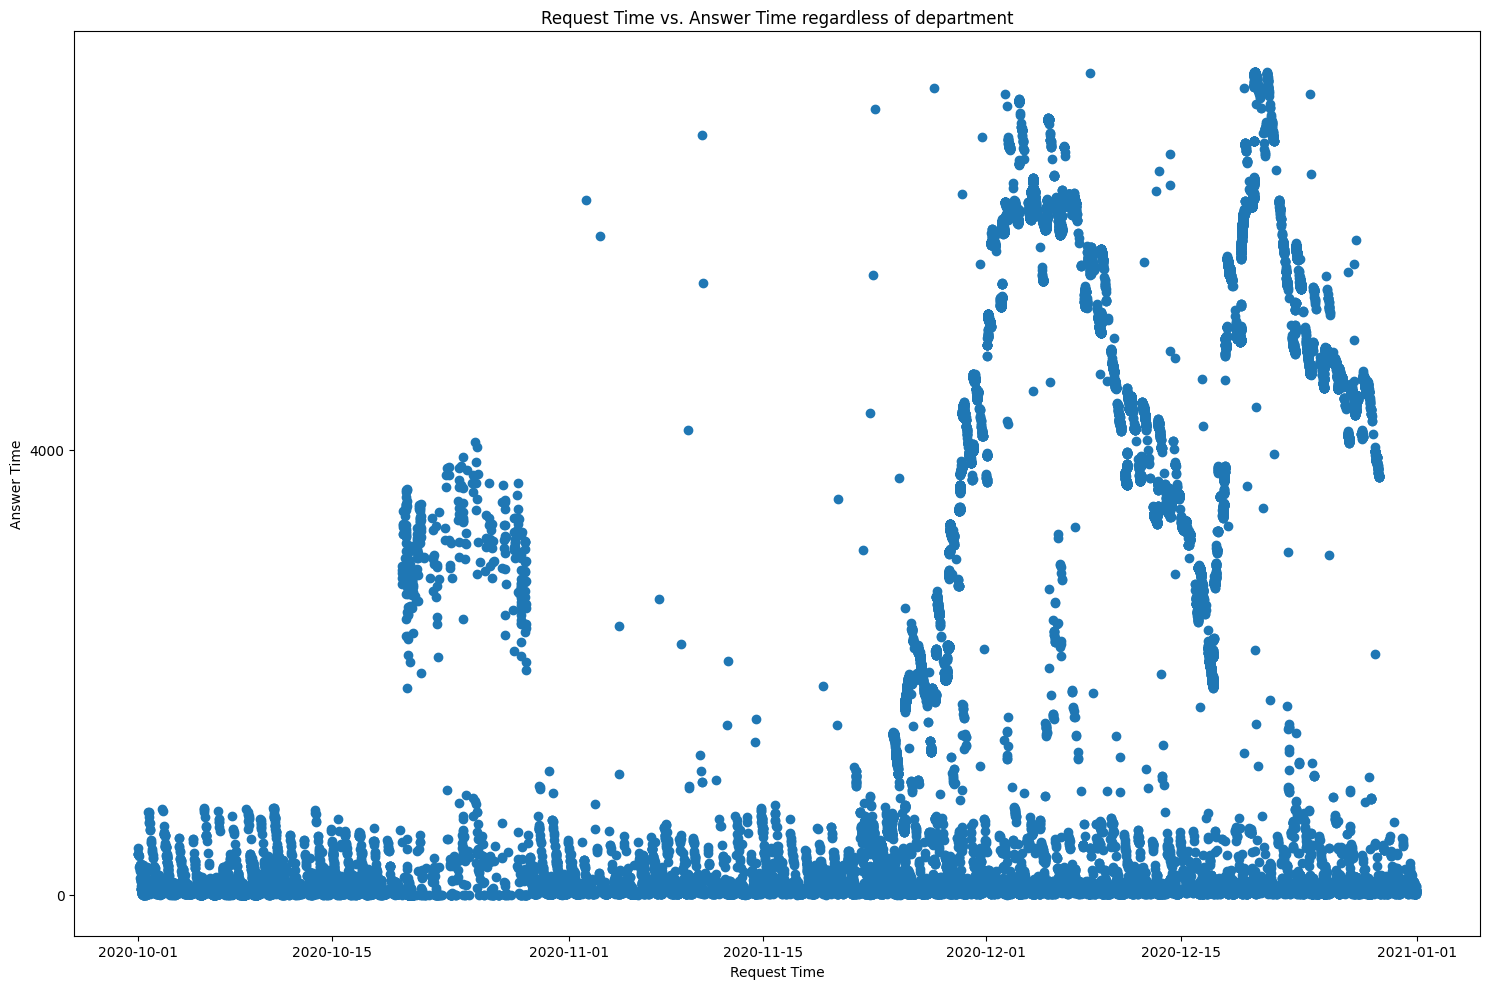

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.scatter(data['request_time'], data['answer_time'])

plt.xlabel("Request Time")
plt.ylabel("Answer Time")
plt.title("Request Time vs. Answer Time regardless of department")
plt.yticks(range(0, int(data['answer_time'].max()) + 100, 4000))
plt.tight_layout()
plt.show()

In [11]:
# Preliminary analysis of the data
# Creating wholesale department dataframe
data_w = data[data['team'] == 'wholesale']

# Creating retail department dataframe
data_r = data[data['team'] == 'retail']

# Analyzing timespan of the data
print("The earliest date of request is -", data['request_time'].min(), ". The last request was committed in -",data_r['request_time'].max())

# Calculating distribution of requests between departments
print("Percentage of requests received by wholesale department is -", round((len(data_w)/len(data))* 100,2),"%. Percentage of requests received by retail department is -",  round((len(data_r)/len(data))*100,2), "%")

# Calculate the number of points
print("The dataset has a size of -",len(data), "points.")

# Number of unique moderators
print("Number of unique moderators is:", data['moderator'].nunique()) 

The earliest date of request is - 2020-10-01 00:58:24 . The last request was committed in - 2020-12-31 22:11:17
Percentage of requests received by wholesale department is - 60.41 %. Percentage of requests received by retail department is - 39.59 %
The dataset has a size of - 35266 points.
Number of unique moderators is: 49


In [12]:
#Code for wholesale department dataframe
# Calculating average answer time per day
avg_answer_t_w = data_w.groupby(data_w.loc[:, 'request_time'].dt.date)['answer_time'].mean()
print('Average answer time in the wholesale department is: ', avg_answer_t_w.mean())

# Calculating amount of requests (in %) with answer time > 45 minutes
long_wait_w = round((data_w.loc[:, 'answer_time'] > 45).mean() * 100, 2)
print('The percentage of long waiting is - ',long_wait_w,'%')

# 15 >= answer time <= 45
normal_wait_w = round(((data_w.loc[:, 'answer_time'] >= 15) & (data_w.loc[:, 'answer_time'] <= 45)).mean() * 100, 2)
print('The percentage of acceptable waiting is - ',normal_wait_w,'%')

# answer time <= 15
short_wait_w = round(((data_w.loc[:, 'answer_time']) <= 15).mean() * 100, 2)
print('The percentage of short waiting is - ',short_wait_w,'%')

# Calculating average work time
average_work_time_w = round((data_w.loc[:, 'work_time']).mean(), 2)
print('The average work time is - ',average_work_time_w)

# Inspecting the amount of times work_time surpassed 5min limit
long_work_time_w = round((data_w.loc[:, 'work_time'] > 5).mean() * 100, 2)
print('The percentage of long work time is - ',long_work_time_w, '%')

# Calculating the namber of unique moderators
moderators_count_w = data_w.loc[:,'moderator'].nunique()
print("Number of moderators is :", moderators_count_w)

# Calculating average response time per moderator
avg_answer_by_moderator_w = data_w.groupby('moderator')['answer_time'].mean()

# Identifying moderators with average response time > 15 minutes (management expectation)
moderators_beyond_expectation_w = avg_answer_by_moderator_w[avg_answer_by_moderator_w > 15].sort_values()

# Identifying moderators with average response time > 45 minutes (generally bad for brand image)
uneffective_moderators_w = avg_answer_by_moderator_w[avg_answer_by_moderator_w > 45].sort_values()

# Number of moderators beyond expectations
number_of_moderators_beyond_expectation_w = len(moderators_beyond_expectation_w)

# Number of moderators beyond expectations
number_of_uneffective_moderators_w = len(uneffective_moderators_w)

print("number of moderators beyond management expectation is:", number_of_moderators_beyond_expectation_w)

print("number of uneffective moderators is:", number_of_uneffective_moderators_w )

# How many requests each moderator handled
mod_counts_w = data_w['moderator'].value_counts()
print("How many requests each moderator handled - ",mod_counts_w)

# 2. Finding the 90th‑percentile count
threshold_w = mod_counts_w.quantile(0.90)
threshold_05_w = mod_counts_w.quantile(0.50)
threshold_01_w = mod_counts_w.quantile(0.10)
print("The 90th percentile is", threshold_w)
print("The 50th percentile is", threshold_05_w)
print("The 10th percentile is", threshold_01_w)


# 3.Top 10% moderators by volume
top_mods_w = mod_counts_w[mod_counts_w >= threshold_w].index

# 4. Counting how many requests those moderators handled
top_requests_w = data_w.loc[data_w['moderator'].isin(top_mods_w)].shape[0]

# 5. Computing the percentage of total requests
total_requests_w = len(data_w)
pct_w = top_requests_w / total_requests_w * 100

print("Moderators in the top 10% handled", pct_w,"% of all requests.")

# How many requests on average each moderator takes daily
data_w.loc[:,'date'] = data_w.loc[:, 'start_time'].dt.date

daily_counts_w = data_w.groupby(['date', 'moderator']).size().reset_index(name='daily_requests_w')
avg_mod_req_w = daily_counts_w.groupby('moderator')['daily_requests_w'].mean().reset_index(name='avg_mod_req_w')

if 'avg_mod_req_r' in data_r.columns: # to avoid errors after executing code more times
    data_r = data_r.drop(columns=['avg_mod_req_w'])
    
data_w = data_w.merge(avg_mod_req_w, on = 'moderator' , how = "left")

# How much more efficient are top 10% moderators 
threshold_daily_w =  avg_mod_req_w.loc[:,'avg_mod_req_w'].quantile(0.90)

top_daily_req_w = avg_mod_req_w[avg_mod_req_w['avg_mod_req_w'] >= threshold_daily_w]['avg_mod_req_w'].mean()
total_daily_req_w = avg_mod_req_w.loc[:,'avg_mod_req_w'].mean()

pct_daily_w = top_daily_req_w / total_daily_req_w * 100

print("Moderators in the top 10% handle during the day ", pct_daily_w,"% more requests than average moderator.")

print( "List of the daily average number of requests handled by moderator:",avg_mod_req_w )

Average answer time in the wholesale department is:  2057.1047807123996
The percentage of long waiting is -  94.94 %
The percentage of acceptable waiting is -  2.71 %
The percentage of short waiting is -  2.36 %
The average work time is -  2.42
The percentage of long work time is -  12.68 %
Number of moderators is : 25
number of moderators beyond management expectation is: 23
number of uneffective moderators is: 23
How many requests each moderator handled -  moderator
188    3733
112    1710
170    1673
181    1538
123    1444
180    1340
102    1311
103    1282
187    1164
125    1142
146     887
153     797
122     761
149     749
116     579
175     417
128     237
161     180
143     141
163     129
144      61
185      25
126       2
129       1
171       1
Name: count, dtype: int64
The 90th percentile is 1619.0000000000002
The 50th percentile is 761.0
The 10th percentile is 11.200000000000008
Moderators in the top 10% handled 33.40217799474277 % of all requests.
Moderators in the

C:\Users\tukhy\AppData\Local\Temp\ipykernel_27816\3192864671.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w.loc[:,'date'] = data_w.loc[:, 'start_time'].dt.date


In [13]:
 # Calculating average answer time per day of the week (to find the most troublesome days of the week)
avg_answer_time_weekday_w = data_w.groupby(data_w['request_time'].dt.day_name())['answer_time'].mean()

# Print the result
print("Average Answer Time per Day of the Week:", avg_answer_time_weekday_w)

 # Calculating average number of requests per day of the week (to find the most troublesome days of the week)
data_w['weekday'] = data_w['request_time'].dt.day_name()

daily_counts_w = data_w.groupby(['date', 'weekday']).size().reset_index(name='daily_requests')
avg_weekday_req_count_w = daily_counts_w.groupby('weekday')['daily_requests'].mean()

# Print the result
print("Average request number per day of the week:", avg_weekday_req_count_w)


Average Answer Time per Day of the Week: request_time
Friday       3354.731420
Monday       3041.775313
Saturday     3709.229351
Sunday       3790.972265
Thursday     2677.091974
Tuesday      3048.184595
Wednesday    3249.236160
Name: answer_time, dtype: float64
Average request number per day of the week: weekday
Friday       99.571429
Monday       76.500000
Saturday     78.622222
Sunday       87.358974
Thursday     63.230769
Tuesday      62.558824
Wednesday    76.690476
Name: daily_requests, dtype: float64


In [14]:
#Code for retail department dataframe
# Calculating average answer time per day
avg_answer_t_r = data_r.groupby(data_r.loc[:, 'request_time'].dt.date)['answer_time'].mean()
print('Average answer time in the retail department is: ', avg_answer_t_r.mean())

# Calculating amount of requests (in %) with answer time > 45 minutes
long_wait_r = round((data_r.loc[:, 'answer_time'] > 45).mean() * 100, 2)
print('The percentage of long waiting is - ',long_wait_r,'%')

# 15 >= answer time <= 45
normal_wait_r = round(((data_r.loc[:, 'answer_time'] >= 15) & (data_r.loc[:, 'answer_time'] <= 45)).mean() * 100, 2)
print('The percentage of acceptable waiting is - ',normal_wait_r,'%')

# answer time <= 15
short_wait_r = round(((data_r.loc[:, 'answer_time']) <= 15).mean() * 100, 2)
print('The percentage of short waiting is - ',short_wait_r,'%')

# Calculating average work time
average_work_time_r = round((data_r.loc[:, 'work_time']).mean(), 2)
print('The average work time is - ',average_work_time_r)

# Inspecting the amount of times work_time surpassed 5min limit
long_work_time_r = round((data_r.loc[:, 'work_time'] > 5).mean() * 100, 2)
print('The percentage of long work time is - ',long_work_time_r, '%')

# Calculating the namber of unique moderators
moderators_count_r = data_r.loc[:,'moderator'].nunique()
print("Number of moderators is :", moderators_count_r)

# Calculating average response time per moderator
avg_answer_by_moderator_r = data_r.groupby('moderator')['answer_time'].mean()

# Identifying moderators with average response time > 15 minutes (management expectation)
moderators_beyond_expectation_r = avg_answer_by_moderator_r[avg_answer_by_moderator_r > 15].sort_values()

# Identifying moderators with average response time > 45 minutes (generally bad for brand image)
uneffective_moderators_r = avg_answer_by_moderator_r[avg_answer_by_moderator_r > 45].sort_values()

# Number of moderators beyond expectations
number_of_moderators_beyond_expectation_r = len(moderators_beyond_expectation_r)

# Number of moderators beyond expectations
number_of_uneffective_moderators_r = len(uneffective_moderators_r)

print("number of moderators beyond management expectation is:", number_of_moderators_beyond_expectation_r)

print("number of uneffective moderators is:", number_of_uneffective_moderators_r )

# How many requests each moderator handled
mod_counts_r = data_r['moderator'].value_counts()
print("How many requests each moderator handled - ",mod_counts_r)

# 2. Finding the 90th‑percentile count
threshold_r = mod_counts_r.quantile(0.90)
threshold_05_r = mod_counts_r.quantile(0.50)
threshold_01_r = mod_counts_r.quantile(0.10)
print("The 90th percentile is", threshold_r)
print("The 50th percentile is", threshold_05_r)
print("The 10th percentile is", threshold_01_r)

# 3.Top 10% moderators by volume
top_mods_r = mod_counts_r[mod_counts_r >= threshold_r].index

# 4. Counting how many requests those moderators handled
top_requests_r = data_r.loc[data_r['moderator'].isin(top_mods_r)].shape[0]

# 5. Computing the percentage of total requests
total_requests_r = len(data_r)
pct_r = top_requests_r / total_requests_r * 100

print("Moderators in the top 10% handled", pct_r,"% of all requests.")

# How many requests on average each moderator takes daily
data_r.loc[:,'date'] = data_r.loc[:, 'start_time'].dt.date

daily_counts_r = data_r.groupby(['date', 'moderator']).size().reset_index(name='daily_requests_r')
avg_mod_req_r = daily_counts_r.groupby('moderator')['daily_requests_r'].mean().reset_index(name='avg_mod_req_r')

if 'avg_mod_req_r' in data_r.columns: # to avoid errors after executing code more times
    data_r = data_r.drop(columns=['avg_mod_req_r'])
    
data_r = data_r.merge(avg_mod_req_r, on = 'moderator' , how = "left")

# How much more efficient are top 10% moderators 
threshold_daily_r =  avg_mod_req_r.loc[:,'avg_mod_req_r'].quantile(0.90)

top_daily_req_r = avg_mod_req_r[avg_mod_req_r['avg_mod_req_r'] >= threshold_daily_r]['avg_mod_req_r'].mean()
total_daily_req_r = avg_mod_req_r.loc[:,'avg_mod_req_r'].mean()

pct_daily_r = top_daily_req_r / total_daily_req_r * 100

print("Moderators in the top 10% handle during the day ", pct_daily_r,"% more requests than average moderator.")

print("List of the daily average number of requests handled by moderator:",avg_mod_req_r)

Average answer time in the retail department is:  106.8693009135908
The percentage of long waiting is -  52.28 %
The percentage of acceptable waiting is -  30.32 %
The percentage of short waiting is -  17.42 %
The average work time is -  1.98
The percentage of long work time is -  7.63 %
Number of moderators is : 24
number of moderators beyond management expectation is: 21
number of uneffective moderators is: 21
How many requests each moderator handled -  moderator
186    1340
117    1247
172     941
135     855
109     827
176     800
121     798
156     748
148     738
136     730
141     711
165     695
164     638
178     622
173     610
111     569
167     534
152     471
114      60
150      16
134       8
133       2
110       1
138       1
Name: count, dtype: int64
The 90th percentile is 915.1999999999999
The 50th percentile is 666.5
The 10th percentile is 3.8000000000000016
Moderators in the top 10% handled 25.268586162440908 % of all requests.
Moderators in the top 10% handle

C:\Users\tukhy\AppData\Local\Temp\ipykernel_27816\644202081.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_r.loc[:,'date'] = data_r.loc[:, 'start_time'].dt.date


In [15]:
#For retail department
 # Calculating average answer time per day of the week (to find the most troublesome days of the week)
avg_answer_time_weekday_r = data_r.groupby(data_r['request_time'].dt.day_name())['answer_time'].mean()

# Print the result
print("Average Answer Time per Day of the Week:", avg_answer_time_weekday_r)

 # Calculating average number of requests per day of the week (to find the most troublesome days of the week)
data_r['weekday'] = data_r['request_time'].dt.day_name()

daily_counts_r = data_r.groupby(['date', 'weekday']).size().reset_index(name='daily_requests')
avg_weekday_req_count_r = daily_counts_r.groupby('weekday')['daily_requests'].mean()

# Print the result
print("Average request number per day of the week:", avg_weekday_req_count_r)
print("Retail department requests",len(data_r))
print("Wholesale department requests",len(data_w))
print("All requests",len(data))

Average Answer Time per Day of the Week: request_time
Friday        82.741465
Monday       121.703472
Saturday      99.620976
Sunday       103.835431
Thursday      75.035458
Tuesday      105.845056
Wednesday     80.589215
Name: answer_time, dtype: float64
Average request number per day of the week: weekday
Friday       56.170732
Monday       30.162791
Saturday     56.725000
Sunday       56.775000
Thursday     70.729730
Tuesday      36.764706
Wednesday    48.875000
Name: daily_requests, dtype: float64
Retail department requests 13962
Wholesale department requests 21304
All requests 35266


In [16]:
#Wholesale department analysis
# Distribution of requests per hour per day (analyzing department service shedule)
 # Step 1: Creating columns for date and hour
data_w['date'] = data_w['request_time'].dt.date
data_w['hour'] = data_w['request_time'].dt.hour

 # Step 2: Count requests per hour per day
requests_per_hour_day_w = data_w.groupby(['date', 'hour']).size().reset_index(name='count')

 # Step 3: Calculate average number of requests per hour across all days
average_requests_by_hour_w = requests_per_hour_day_w.groupby('hour')['count'].mean()

print("The average amount of requests in certain hours :", average_requests_by_hour_w)

# Calculate average answer time by hour (analyzing long answers more thoroughly)
avg_answer_time_by_hour_w = data_w.groupby(data['request_time'].dt.hour)['answer_time'].mean()
print("The average answer time per hour is:", avg_answer_time_by_hour_w)

The average amount of requests in certain hours : hour
0      7.140845
1     18.111111
2     21.469880
3     24.573333
4     12.168831
5     15.102564
6     18.534884
7     21.843373
8     26.908046
9     20.380952
10    10.805195
11     9.107143
12     9.444444
13    10.320988
14    10.262500
15     9.797297
16     6.161765
17     4.150000
18     2.461538
19     2.903226
20     5.296296
21     5.727273
22     4.000000
23     4.196078
Name: count, dtype: float64
The average answer time per hour is: request_time
0.0     3579.743381
1.0     3864.271056
2.0     3919.321147
3.0     3986.242249
4.0     3794.974608
5.0     3861.579138
6.0     3627.641380
7.0     3585.248625
8.0     3541.302180
9.0     3280.252200
10.0    2908.898023
11.0    2962.045100
12.0    2859.631159
13.0    3071.206266
14.0    2979.898929
15.0    2917.696109
16.0    3139.226878
17.0    3105.942830
18.0    2743.629944
19.0    2751.817785
20.0    3045.784428
21.0    2943.493504
22.0    2992.407421
23.0    3119.481974
Nam

In [17]:
#Retail department
# Distribution of requests per hour per day (analyzing department service shedule)
 # Step 1: Creating columns for date and hour
data_r['date'] = data_r['request_time'].dt.date
data_r['hour'] = data_r['request_time'].dt.hour

 # Step 2: Count requests per hour per day
requests_per_hour_day_r = data_r.groupby(['date', 'hour']).size().reset_index(name='count')

 # Step 3: Calculate average number of requests per hour across all days
average_requests_by_hour_r = requests_per_hour_day_r.groupby('hour')['count'].mean()

print("The average amount of requests in certain hours :", average_requests_by_hour_r)

# Calculate average answer time by hour (analyzing long answers more thoroughly)
avg_answer_time_by_hour_r = data_r.groupby(data_r['request_time'].dt.hour)['answer_time'].mean()
print("The average answer time per hour is:", avg_answer_time_by_hour_r)

The average amount of requests in certain hours : hour
0      2.052632
1      1.823529
2      1.450000
3      1.909091
4      2.204082
5      3.698630
6      5.121951
7      8.459770
8     10.274725
9     13.522727
10    12.725275
11    15.411111
12    12.910112
13    12.777778
14    10.179775
15     8.696629
16     6.611765
17     6.772727
18     6.976471
19     7.229885
20     6.023256
21     4.037500
22     3.283582
23     2.686275
Name: count, dtype: float64
The average answer time per hour is: request_time
0     414.552160
1     350.281720
2     310.907582
3     261.401903
4     178.023878
5     154.065578
6      79.188159
7      86.449084
8      61.113377
9      76.770282
10     65.800284
11     66.905461
12     55.487478
13     71.607116
14     75.239962
15     67.305486
16     95.885763
17     94.527082
18     87.648827
19     83.865243
20    100.274792
21    235.386901
22    347.679015
23    487.729805
Name: answer_time, dtype: float64


In [18]:
#Wholesale department analysis
# Distribution of starts per hour per day (analyzing department service shedule)
 # Step 1: Creating columns for date and hour
data_w['date'] = data_w['start_time'].dt.date
data_w['hour'] = data_w['start_time'].dt.hour

 # Step 2: Counting starts per hour per day
starts_per_hour_day_w = data_w.groupby(['date', 'hour']).size().reset_index(name='count_t')

 # Step 3: Calculating average number of requests per hour across all days
average_starts_by_hour_w = starts_per_hour_day_w.groupby('hour')['count_t'].mean()

print("The average amount of starts in certain hours :", average_starts_by_hour_w)

The average amount of starts in certain hours : hour
0      6.000000
6      1.000000
7     24.975000
8     29.237500
9     27.080000
10    30.027397
11    23.302632
12    23.424658
13    15.169014
14    19.925373
15    14.523077
16    16.463768
17    18.730769
18    20.160000
19    15.883721
20    17.795918
21    14.472222
22    20.647059
23     1.333333
Name: count_t, dtype: float64


In [19]:
#Retail department analysis
# Distribution of starts per hour per day (analyzing department service shedule)
 # Step 1: Creating columns for date and hour
data_r['date'] = data_r['start_time'].dt.date
data_r['hour'] = data_r['start_time'].dt.hour

 # Step 2: Counting starts per hour per day
starts_per_hour_day_r = data_r.groupby(['date', 'hour']).size().reset_index(name='count_t')

 # Step 3: Calculating average number of requests per hour across all days
average_starts_by_hour_r = starts_per_hour_day_r.groupby('hour')['count_t'].mean()

print("The average amount of starts in certain hours :", average_starts_by_hour_r)

The average amount of starts in certain hours : hour
6      1.000000
7     17.385542
8      9.593750
9     17.162500
10    13.203704
11    20.088608
12    13.338462
13    21.807229
14    12.365079
15    11.475000
16     9.984615
17     9.819444
18     8.945455
19    11.761194
20     9.500000
21     7.983051
22     5.324324
23     1.000000
Name: count_t, dtype: float64


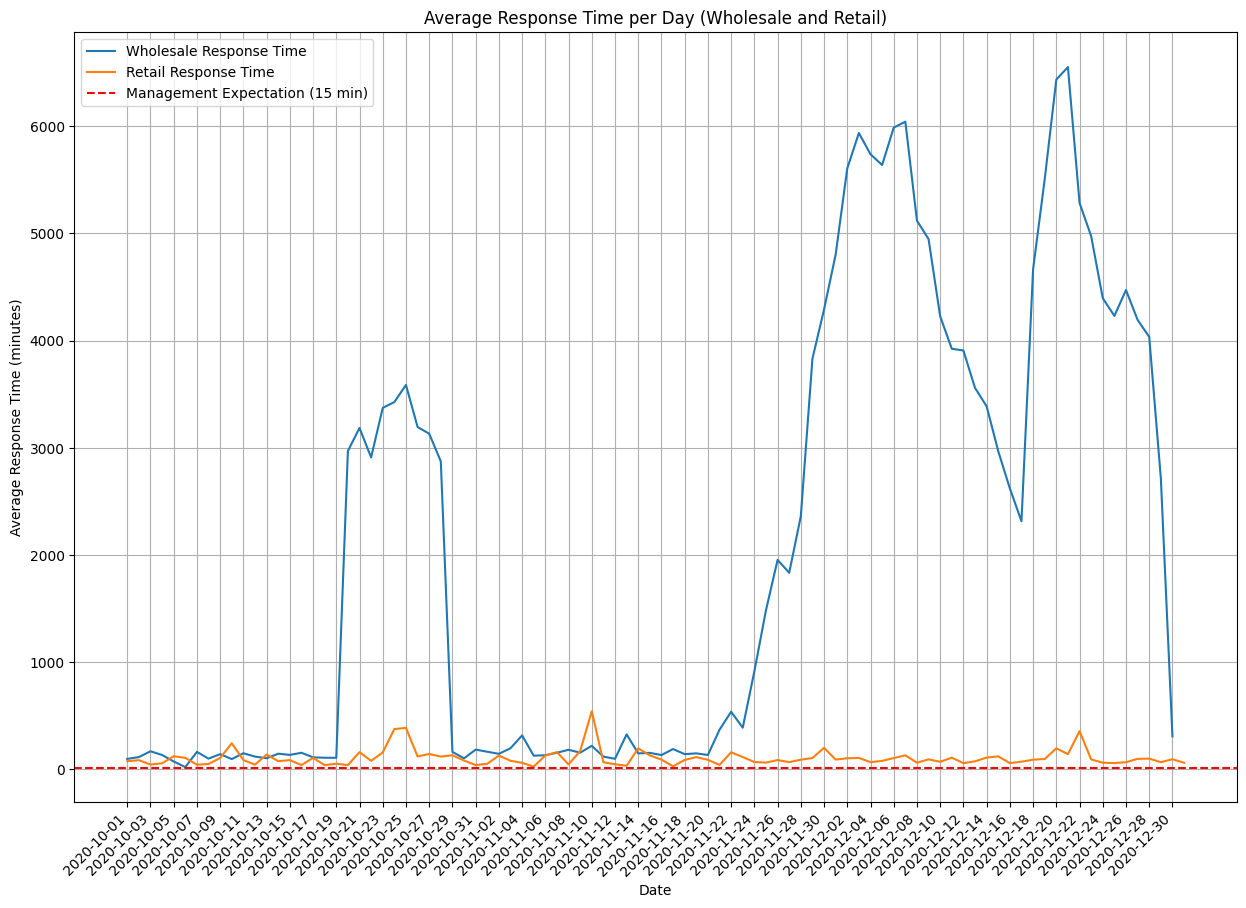

In [20]:
import matplotlib.pyplot as plt
# Plot average response time per day
plt.figure(figsize=(15, 10))
avg_answer_t_w.plot(label='Wholesale Response Time')
avg_answer_t_r.plot(label='Retail Response Time')

plt.axhline(15, color='red', linestyle='--', label='Management Expectation (15 min)')
plt.title('Average Response Time per Day (Wholesale and Retail)')
plt.ylabel('Average Response Time (minutes)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

plt.xticks(avg_answer_t_w.index[::2], rotation=45, ha='right')  # show every 2nd date
plt.show()



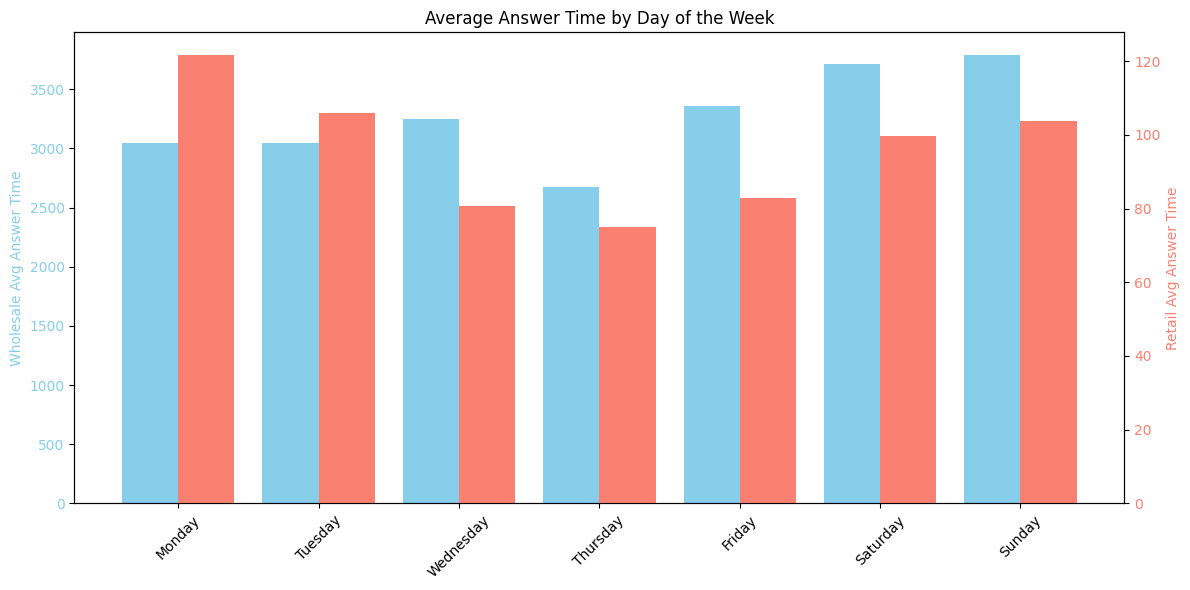

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the order of weekdays
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex to ensure order
avg_answer_time_weekday_w = avg_answer_time_weekday_w.reindex(day_order)
avg_answer_time_weekday_r = avg_answer_time_weekday_r.reindex(day_order)

# Set up figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar width and x positions
x = range(len(day_order))
bar_width = 0.4

# Plot Wholesale (left y-axis)
ax1.bar([i - bar_width/2 for i in x], avg_answer_time_weekday_w.values, 
        width=bar_width, color='skyblue', label='Wholesale')
ax1.set_ylabel('Wholesale Avg Answer Time', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Twin axis for Retail (right y-axis)
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], avg_answer_time_weekday_r.values, 
        width=bar_width, color='salmon', label='Retail')
ax2.set_ylabel('Retail Avg Answer Time', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(day_order, rotation=45)

# Title and layout
plt.title('Average Answer Time by Day of the Week')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

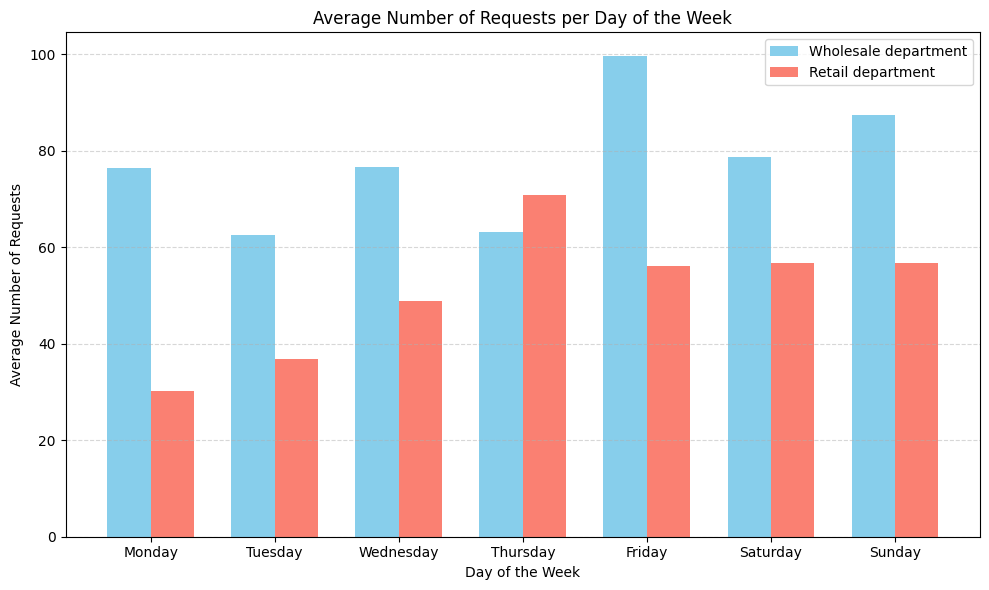

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


# Define the order of weekdays
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex to ensure order
avg_weekday_req_count_w = avg_weekday_req_count_w.reindex(day_order)
avg_weekday_req_count_r = avg_weekday_req_count_r.reindex(day_order)

# Create the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
r1 = range(len(avg_weekday_req_count_w))
plt.bar(r1, avg_weekday_req_count_w.values, width=bar_width, color='skyblue', label='Wholesale department')

# Bars for Retail, shifted
r2 = [x + bar_width for x in r1]
plt.bar(r2, avg_weekday_req_count_r.values, width=bar_width, color='salmon', label='Retail department')

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Requests')
plt.title('Average Number of Requests per Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Day labels in consistent order (adjust if your data index has a different order)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks([r + bar_width / 2 for r in range(len(avg_weekday_req_count_w))], day_order)

plt.tight_layout()
plt.legend()
plt.show()


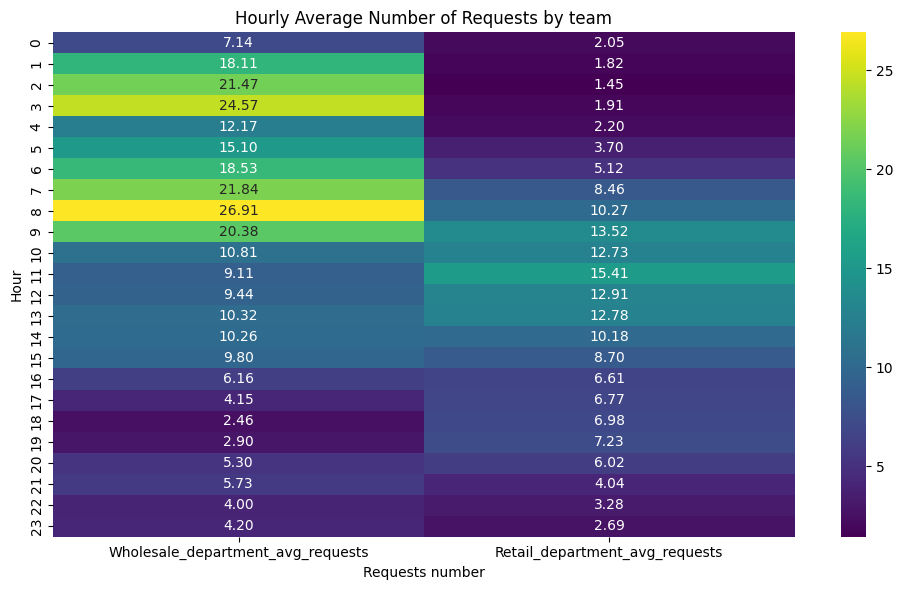

In [23]:
import seaborn as sns # to create heatmap
import pandas as pd
import matplotlib.pyplot as plt

#Creating a heatmap of response time by hour/day
# Combining the two Series into a DataFrame
hourly_data = pd.DataFrame({
    'Wholesale_department_avg_requests': average_requests_by_hour_w,
    'Retail_department_avg_requests': average_requests_by_hour_r
})

# Creating the heatmap
plt.figure(figsize=(10, 6))  
sns.heatmap(hourly_data, cmap='viridis', annot=True, fmt=".2f")  

# Adding labels and title
plt.xlabel('Requests number')
plt.ylabel('Hour')
plt.title('Hourly Average Number of Requests by team')

plt.tight_layout()  # to prevent labels from overlapping
plt.show()


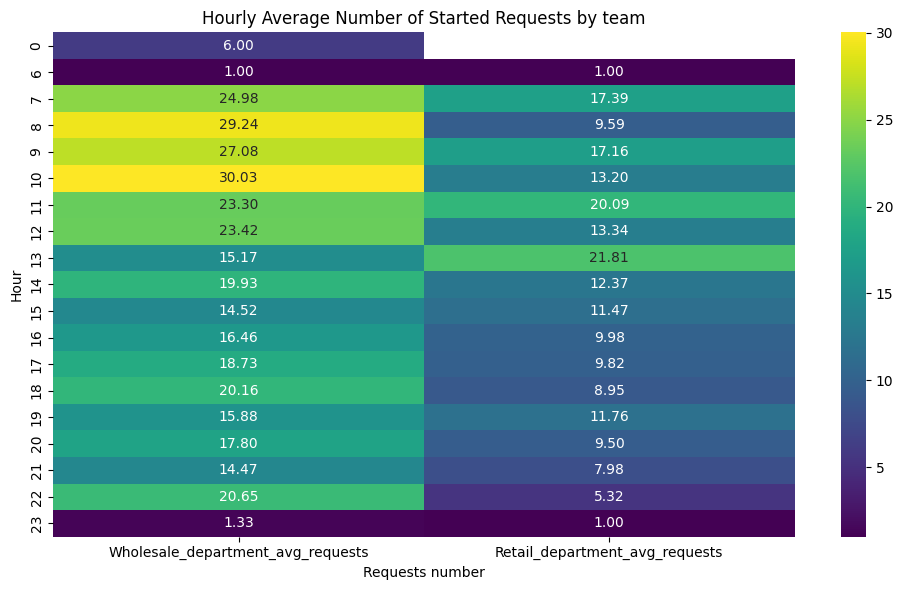

In [24]:
import seaborn as sns # to create heatmap
import pandas as pd
import matplotlib.pyplot as plt

#Creating a heatmap of response time by hour/day
# Combining the two Series into a DataFrame
hourly_data = pd.DataFrame({
    'Wholesale_department_avg_requests': average_starts_by_hour_w,
    'Retail_department_avg_requests': average_starts_by_hour_r
})

# Creating the heatmap
plt.figure(figsize=(10, 6))  
sns.heatmap(hourly_data, cmap='viridis', annot=True, fmt=".2f")  

# Adding labels and title
plt.xlabel('Requests number')
plt.ylabel('Hour')
plt.title('Hourly Average Number of Started Requests by team')

plt.tight_layout()  # to prevent labels from overlapping
plt.show()

<Figure size 1500x500 with 0 Axes>

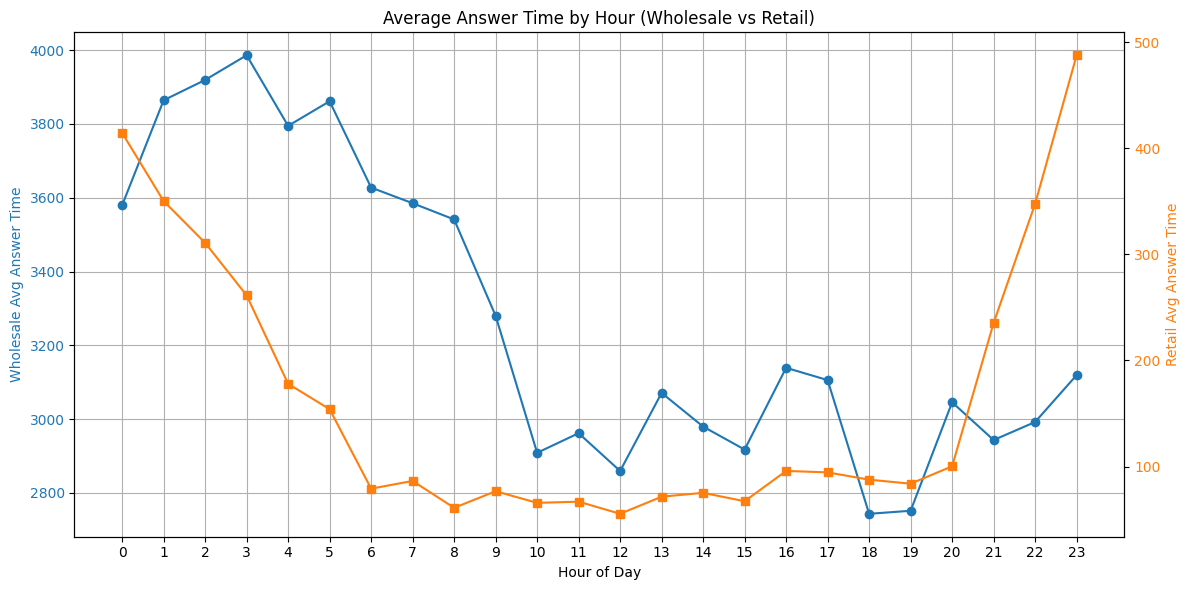

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
# Creating the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Wholesale on left y-axis
color_w = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Wholesale Avg Answer Time', color=color_w)
ax1.plot(avg_answer_time_by_hour_w.index, avg_answer_time_by_hour_w, color=color_w, marker='o', label='Wholesale')
ax1.tick_params(axis='y', labelcolor=color_w)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Retail on right y-axis
color_r = 'tab:orange'
ax2.set_ylabel('Retail Avg Answer Time', color=color_r)
ax2.plot(avg_answer_time_by_hour_r.index, avg_answer_time_by_hour_r, color=color_r, marker='s', label='Retail')
ax2.tick_params(axis='y', labelcolor=color_r)

# Title and grid
plt.title('Average Answer Time by Hour (Wholesale vs Retail)')
ax1.grid(True)
ax1.set_xticks(range(0, 24))  # Show all 24 hours on x-axis

plt.tight_layout()
plt.show()